# Vehicle Detection 

In [1]:
import requests, io, os, glob
import pickle, zipfile
import functools
import collections
import time
from random import choice
from multiprocessing import Pool

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image

from skimage.feature import hog
from skimage.measure import label, regionprops
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Prepare environment

#### Download datasets and prepare environment¶

In [2]:
# Download dataset
data_dir = 'data'
vehicle_url = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip'
vehicle_zip = os.path.join(data_dir, 'vehicles.zip')
non_vehicle_url = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'
non_vehicle_zip = os.path.join(data_dir, 'non-vehicles.zip')

def download_zip(zip_file, zip_url):
    if not os.path.isfile(zip_file): 
        print("Downloading {}".format(zip_url))
        r = requests.get(zip_url, allow_redirects=True)
        open(zip_file, 'wb').write(r.content)
        print("Done.")
    else:
        print("Already exists {}".format(zip_url))

if not os.path.exists('data'): os.mkdir(data_dir)
download_zip(vehicle_zip, vehicle_url)
download_zip(non_vehicle_zip, non_vehicle_url)

output_images = 'output_images'
if not os.path.exists(output_images): os.mkdir(output_images)


Already exists https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
Already exists https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip


#### Create generators to read images from archive

In [3]:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n): yield l[i:i+n]

# Generator to read images from archve
def image_reader(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as z:
        for i in z.infolist():
            if not i.filename.startswith("_") and i.filename.endswith('png'):
                img = mpimg.pil_to_array(Image.open(io.BytesIO(z.read(i))))
                yield img.astype(np.float32)/255 
                
# Generator to read images from archve
def image_reader_chunks(zip_file, chunk_size):
    with zipfile.ZipFile(zip_file, 'r') as z:
        l = list(filter(lambda i: not i.filename.startswith("_") and i.filename.endswith('png'), z.infolist()))
        for c in chunks(l, chunk_size):
            yield list(map(lambda i: mpimg.pil_to_array(Image.open(io.BytesIO(z.read(i)))).astype(np.float32)/255, c))


#### Read n samples from archive

In [4]:
# read n samples from archive
def read_samples(num, step, zip_file):
    samples = []
    count = 0
    for i in image_reader(zip_file):
        if count % step == 0 and len(samples) < num: samples.append(i)
        count += 1
    return samples, count

def show_samples(samples):
    size = len(samples)
    f, ax = plt.subplots(1, size, figsize = (18, 16))
    for i, img in enumerate(samples):
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()
        

In [5]:
cars_samples, cars_count = read_samples(6, 100, vehicle_zip) 
non_cars_samples, non_cars_count = read_samples(6, 100, non_vehicle_zip)  

Vehicle samples (Total number: 8792)


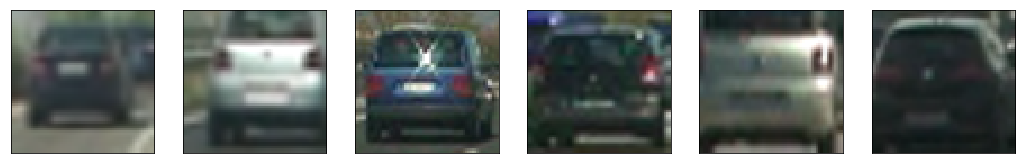

Non-Vehicle samples (Total number: 8968)


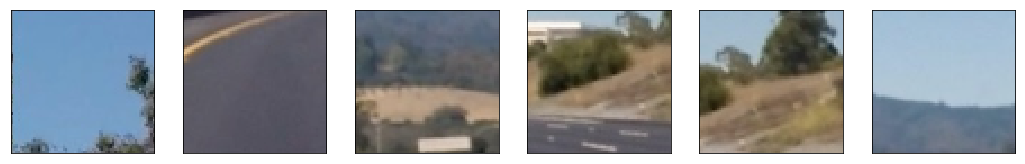

In [6]:
print('Vehicle samples (Total number: {})'.format(cars_count))
show_samples(cars_samples)
print('Non-Vehicle samples (Total number: {})'.format(non_cars_count))
show_samples(non_cars_samples)


### Feature extraction

In [7]:
sample_shape = cars_samples[0].shape
feature_image_shape = sample_shape[0:2]
print(feature_image_shape)

(64, 64)


In [78]:
# Feature extraction help functions

#convert one color-schema to another
color_conversion = lambda image, color_space: np.copy(image) if color_space else cv.cvtColor(image, color_space)

# Function to return HOG features and visualization
def visual_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vector=True):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                              visualise=True, feature_vector=feature_vector)

# Function to return HOG features
def hog_features(img, orient, pix_per_cell, cell_per_block, feature_vector=True):
        return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector)     

# Hog feature factory    
def create_hog_features(orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    def fn(img):
        hog_img = feature_image[:,:,hog_channel]
        return hog_features(hog_img, orient, pix_per_cell, cell_per_block)
    return fn    

# Hog factory for all chanhels
def create_all_hog_features(orient=9, pix_per_cell=8, cell_per_block=2):
    def fn(img):
        features = []
        for channel in range(img.shape[2]):
            features.append(hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block))
        return np.ravel(features)
    return fn  

# Define a function to compute color histogram features , bins_range= =(0, 256) for non- mpimg!
def create_color_hist(nbins=32, bins_range=(0, 1)): #bins_range=(0, 256)):
    def fn(img):  
        # Compute the histogram of the color channels separately
        channel_hist = [ np.histogram(img[:,:,i], bins=nbins, range=bins_range)[0] for i in range(0,3) ]
        # Concatenate the histograms into a single feature vector
        return np.concatenate(channel_hist)
    return fn

# Factory for function to compute binned color features  
def create_bin_spatial(size=(32, 32)):
    def fn(img):
        # Use cv2.resize().ravel() to create the feature vector
        return cv.resize(img, size).ravel()
    return fn

# Extract image feature vectors
def extract_image_features(image, color_space=None, features_list = ()):
    # apply color conversion if other than 'RGB'
    feature_image = color_conversion(image, color_space)
    features = [ fn(feature_image) for fn in features_list ]
    return np.concatenate(features)


#### Show hog for sample images

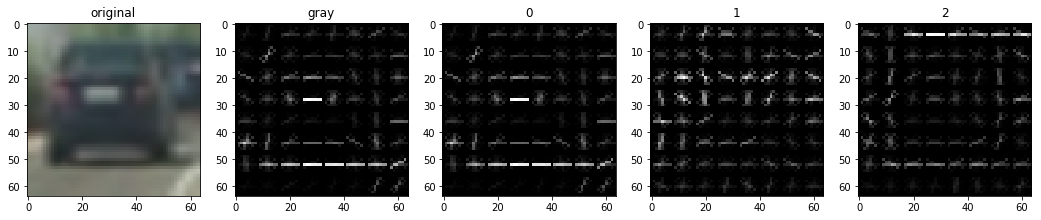

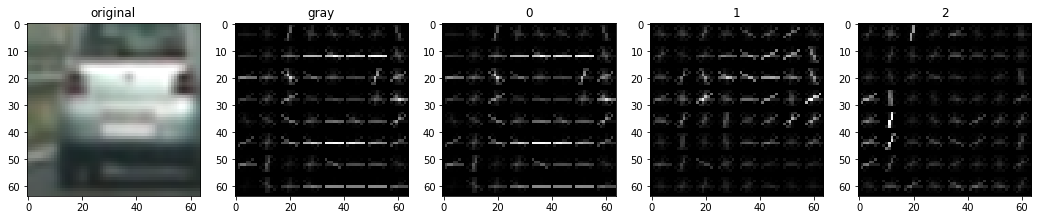

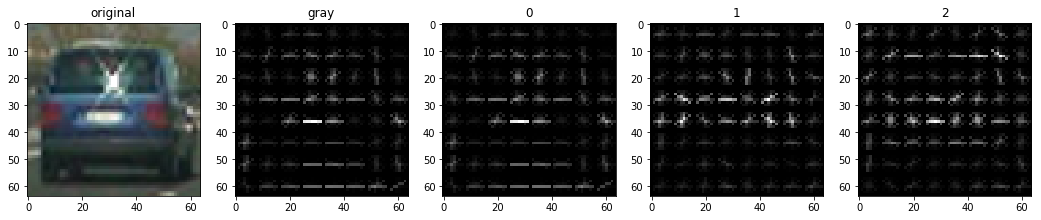

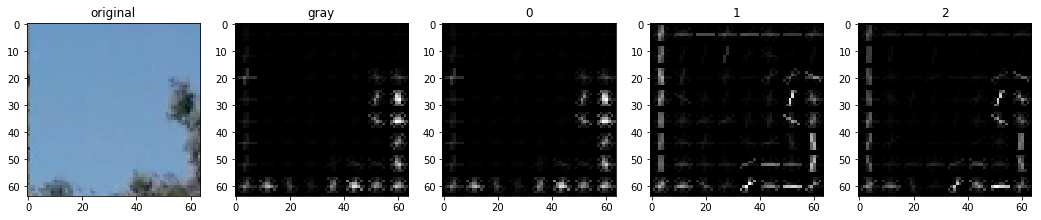

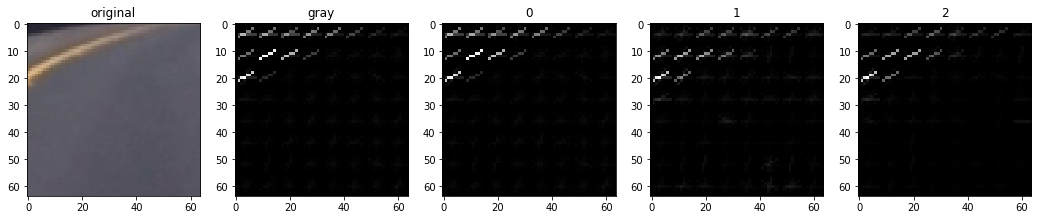

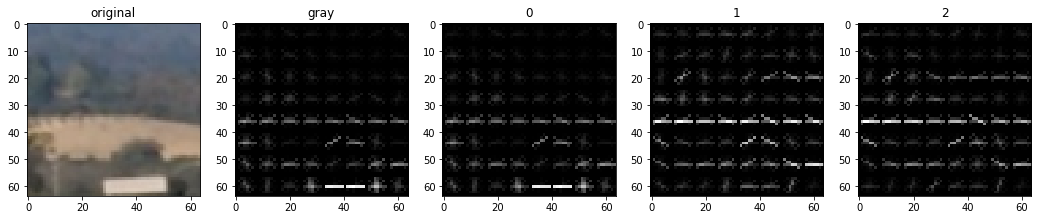

In [80]:
hog_samples = cars_samples[:3] + non_cars_samples[:3]

def show_hog(img, orient = 9, pix_per_cell = 8, cell_per_block = 2):
    def hog_plot_img(src_img, ax, title):
        f, h_img = visual_hog_features(src_img, orient, pix_per_cell, cell_per_block)
        ax.imshow(h_img, cmap = 'gray')
        ax.set_title(title)
    
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    conv = cv.cvtColor(img, cv.COLOR_RGB2YCrCb)
    fg, ax = plt.subplots(1, 5, figsize = (18, 16))
    ax[0].imshow(img)
    ax[0].set_title('original')
    
    hog_plot_img(gray, ax[1], 'gray')
    hog_plot_img(conv[:,:,0], ax[2], '0')
    hog_plot_img(conv[:,:,1], ax[3], '1')
    hog_plot_img(conv[:,:,2], ax[4], '2')
                 
    plt.show()

for i in hog_samples: show_hog(i)


In [81]:
# Feature exctraction parameters
color_space = cv.COLOR_RGB2YCrCb # COLOR_RGB2HSV, COLOR_RGB2LUV, COLOR_RGB2HLS, COLOR_RGB2YUV, COLOR_RGB2YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

feature_fn_list = [create_bin_spatial(spatial_size), 
                   create_color_hist(nbins=hist_bins), 
                   create_all_hog_features(orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block) ]
                   
def process_chunk_features(img_list):
    fs = []
    for img in img_list:
        img_f = extract_image_features(img, color_space=color_space, features_list = feature_fn_list)           
        fs.append(img_f) 
    return fs

def read_chunk_features(zip_file):
    pool = Pool(5)
    res = pool.map(process_chunk_features, image_reader_chunks(zip_file, 100))
    pool.close()
    pool.join()
    return [f for c in res for f in c]


%time car_features = read_chunk_features(vehicle_zip)
%time non_car_features = read_chunk_features(non_vehicle_zip)

def read_features(zip_file):
    fs = []
    for img in image_reader(zip_file):
        img_f = extract_image_features(img, color_space=color_space, features_list = feature_fn_list)           
        fs.append(img_f)                       
    return fs

#%time car_features = read_features(vehicle_zip)
# for img in image_reader(vehicle_zip):
#     img_f = extract_image_features(img, color_space=color_space, features_list = feature_fn_list)           
#     car_features.append(img_f)                       
                   
# notcar_features = []
# for img in image_reader(non_vehicle_zip):
#     img_f = extract_image_features(img, color_space=color_space, features_list = feature_fn_list)           
#     notcar_features.append(img_f) 


CPU times: user 5.17 s, sys: 7.99 s, total: 13.2 s
Wall time: 21 s
CPU times: user 5.08 s, sys: 8.22 s, total: 13.3 s
Wall time: 21.4 s


#### Define and Train a classifier

In [82]:
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
%time svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9048
CPU times: user 33 s, sys: 2.36 s, total: 35.4 s
Wall time: 37 s
Test Accuracy of SVC =  0.9848


#### Serialize trained clasifier into pickle file - for reuse

In [83]:
to_pickle = {}
to_pickle['clf'] = svc
to_pickle['color_space'] = color_space
to_pickle['scaler'] = X_scaler
to_pickle['orient'] = orient
to_pickle['pix_per_cell'] = pix_per_cell
to_pickle['cell_per_block'] = cell_per_block
to_pickle['spatial_size'] = spatial_size
to_pickle['hist_bins'] = hist_bins
pickle.dump( to_pickle, open( "model-reg.pkl", "wb" ))

#### Load trained clasifier from file

In [84]:
from_pickle = pickle.load(open('model-reg.pkl', 'rb'))
search_clf = from_pickle['clf']
color_space = from_pickle['color_space']
search_scaler = from_pickle['scaler']
orient = from_pickle['orient']
pix_per_cell = from_pickle['pix_per_cell'] 
cell_per_block = from_pickle['cell_per_block']
spatial_size = from_pickle['spatial_size']
hist_bins = from_pickle['hist_bins']
print(from_pickle)

{'orient': 10, 'color_space': 37, 'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'cell_per_block': 2, 'hist_bins': 32, 'spatial_size': (32, 32), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pix_per_cell': 8}


#### Help types and functions for processing video

In [126]:
#cRepresents search window
Window = collections.namedtuple('Window', ['x1', 'y1', 'x2', 'y2', 'region'])
Window.__new__.__defaults__ = (0, 0, 0, 0, 0)

#calculate step to get next window
step_size = lambda size, overlap: np.int(size * (1 - overlap))  
#number of windows per dimention
number_of_windows = lambda size, window_size, step: np.int(size/step) - np.int(window_size/step) + 1


In [127]:
# Function to draw boxes on top of an image
def draw_boxes(img, bboxes, y_prefix=0, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    img_copy = np.copy(img)
    # Iterate through the bounding boxes
    for b in bboxes: cv.rectangle(img_copy, (b.x1, b.y1 + y_prefix), (b.x2, b.y2 + y_prefix), color, thick)
    return img_copy

In [128]:
# Class for finding the slide windows on a given image shape
class Region:
    def __init__(self, w, window_shape, step, scale, num):
        self.w = w
        self.width = w.x2 - w.x1
        self.heigth = w.y2 - w.y1 
        self.shape = window_shape
        self.scale = scale
        self.x_step = step #step_size(window_shape[0], overlap[0])
        self.y_step = step #step_size(window_shape[1], overlap[1])
        self.x_windows = number_of_windows(self.width, window_shape[0], self.x_step) 
        self.y_windows = number_of_windows(self.heigth, window_shape[1], self.y_step)
        self.num = num
    
    def to_window(self, x_num, y_num): # calculate window position
        startx = self.w.x1 + ( x_num * self.x_step )
        endx = startx + self.shape[0]
        starty = self.w.y1 + ( y_num * self.y_step )
        endy = starty + self.shape[1]
        return Window(x1=startx, y1=starty, x2=endx, y2=endy, region=self.num)
    
    def to_windows(self): # calculate all windows
        return [ self.to_window(x, y) for y in range(self.y_windows) for x in range(self.x_windows) ]


# create slide windows for a list of Regions
def create_windows(regions):
    return functools.reduce(lambda w, r: w + r.to_windows(), regions, [])

# scale image 
def rescale_image(img, scale):
    return img if scale == 1 else cv.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))

#prepare image for processing: normalize, crop, convert color
def prepare_image(img, y_start, y_stop):
    proc_img = img.astype(np.float32)/255.0
    sub_img = proc_img[y_start: y_stop, :, :]
    return color_conversion(sub_img, color_space)

In [129]:
y_prefix = 380

# List of slide windows regions 
test_regions = [
#     Region(Window(x1=0, y1=0, x2=1280, y2=160), (80,80), (0.75, 0.75), 1.25),
    Region(Window(x1=0, y1=0, x2=1280, y2=120), (96,96), 12, 1.5, 0),
    Region(Window(x1=0, y1=32, x2=1280, y2=286), (128,128), 16, 2, 1)
]
#'min_rows':[380, 412], 'max_rows':[500, 660], 

# Precreate list of slide windows
search_windows = create_windows(test_regions)
print(len(search_windows))

881


#### Draw all slide windows on a test image

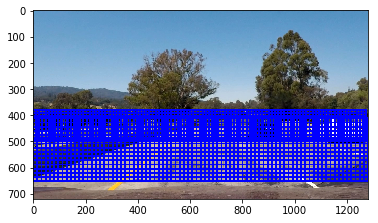

In [130]:
test_img = mpimg.imread('test_images/test1.jpg')
window_img = draw_boxes(test_img, search_windows, y_prefix=y_prefix, color=(0,0,255), thick = 6)
plt.figure()
plt.imshow(window_img)

### Process video

In [131]:
# number of hog blocks per 64x64 image 
hog_blocks_per_window = 7 

# image feature functions list to extract (HOG will be extracted separately)
w_feature_fn_list = [ 
     create_bin_spatial(spatial_size),
     create_color_hist(nbins=hist_bins) 
]

# process pool size
pool_size = 6


In [140]:
# Per-process cache to speed up performance
search_cache = {}

# init cache with frame image to process
def init_cache_map(img, count):
    global search_cache
    if not search_cache.get(count):
        search_cache = {count: count, 'img': img }
    return None

# clean cache 
def clean_cache(s):
    global search_cache
    search_cache = {}

# get image from cache
def get_cached_image():
    return search_cache['img']

# get hog for window w from whole image in cache 
def get_cached_hog(w):
    #print("get hog from cache ", w)
    img = search_cache['img']
    k = 'hog_' + str(w.region)
    hog = search_cache.get(k)
    r = test_regions[w.region]
    if not hog:
        r = test_regions[w.region]
        i = img[r.w.y1: r.w.y2, :, :]
        scaled_img = rescale_image(i, r.scale)
        hog1 = hog_features(scaled_img[:,:,0], orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog2 = hog_features(scaled_img[:,:,1], orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog3 = hog_features(scaled_img[:,:,2], orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog = {'1':hog1, '2': hog2, '3': hog3 }
        search_cache[k] = hog
    hx = int(w.x1//r.scale) // pix_per_cell
    hy = int((w.y1-r.w.y1)//r.scale) // pix_per_cell
    hog_f1 = hog['1'][hy:hy + hog_blocks_per_window, hx:hx + hog_blocks_per_window].ravel() 
    hog_f2 = hog['2'][hy:hy + hog_blocks_per_window, hx:hx + hog_blocks_per_window].ravel() 
    hog_f3 = hog['3'][hy:hy + hog_blocks_per_window, hx:hx + hog_blocks_per_window].ravel() 
    hog_f = np.hstack((hog_f1, hog_f2, hog_f3)) 
    return hog_f
          

In [133]:
# find if a window is a candidate (contains a car)
def analyze_window(window):
    cached_img = get_cached_image()
    hog_f = get_cached_hog(window)
    
    window_img = cached_img[window.y1:window.y2, window.x1:window.x2, :]
    w_img = cv.resize(window_img, feature_image_shape)
    
    w_fn_f = [ fn(w_img) for fn in w_feature_fn_list ]
    w_fn_f.append(hog_f)
    w_features = np.concatenate(w_fn_f)
    
    # Scale extracted features to be fed to classifier
    scaled_features = search_scaler.transform(np.array(w_features).reshape(1, -1))
    # Predict using your classifier
    confidence = search_clf.decision_function(scaled_features)
    prediction = search_clf.predict(scaled_features)
    return prediction == 1 and abs(confidence) > 0.9

# analyze all windows in a list
def analyze_windows(window_list):
    candidates = []
    for window in window_list:
        prediction = analyze_window(window)
        if prediction: candidates.append(window)
    return candidates  

class AnalyzeFn(object):
    def __init__(self, img, count):
        self.img = img
        self.count = count
        
    def __call__(self, l): 
        init_cache_map(self.img, self.count)
        return analyze_windows(l)

# process frame image for candidates
def f_candidates(img, count, pool, step=100):
    fn = AnalyzeFn(img, count)
    #res = pool.map(init_cache_map, [img] * pool_size) # initialize pool with image
    res = pool.map(fn, chunks(search_windows, step)) # process search windows in chunks 
    return [f for c in res for f in c]


In [134]:
# Function to add boxed regions to a heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for b in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[b.y1:b.y2, b.x1:b.x2] += 1

    return heatmap

# Function to apply a threshold on a heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

# Function to infer labels from a list of boxes
def bbox_from_labels(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = Window(x1=np.min(nonzerox), y1=np.min(nonzeroy), x2=np.max(nonzerox), y2=np.max(nonzeroy))
        # Append the box to the list
        bbox_list.append(bbox)
    return bbox_list

CPU times: user 459 ms, sys: 59.8 ms, total: 519 ms
Wall time: 728 ms


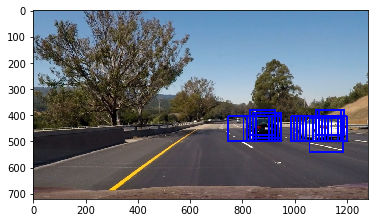

CPU times: user 421 ms, sys: 65.9 ms, total: 487 ms
Wall time: 642 ms


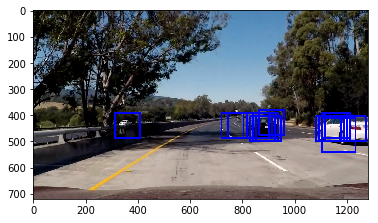

CPU times: user 371 ms, sys: 54.6 ms, total: 425 ms
Wall time: 593 ms


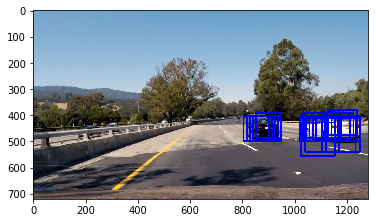

CPU times: user 311 ms, sys: 56.5 ms, total: 367 ms
Wall time: 663 ms


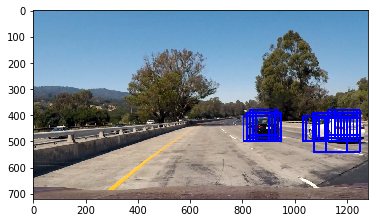

CPU times: user 254 ms, sys: 44 ms, total: 298 ms
Wall time: 640 ms


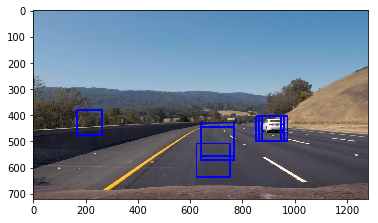

CPU times: user 326 ms, sys: 62.4 ms, total: 388 ms
Wall time: 597 ms


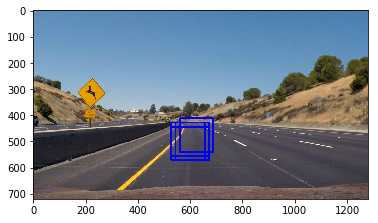

In [146]:
test_imgs = glob.glob('test_images/*.jpg')
with Pool(pool_size) as test_pool:
    for i, img in enumerate(test_imgs):
        img = mpimg.imread(img)
        search_img = prepare_image(img, 380, 656) 
        %time candidates = f_candidates(search_img, i, test_pool, step=225)
        window_img = draw_boxes(img, candidates, y_prefix=y_prefix, color=(0,0,255), thick = 6)
        plt.figure()
        plt.imshow(window_img)
        plt.show()

test_pool.join()   


#### Run search over test images and apply heat map

CPU times: user 380 ms, sys: 53.4 ms, total: 433 ms
Wall time: 640 ms


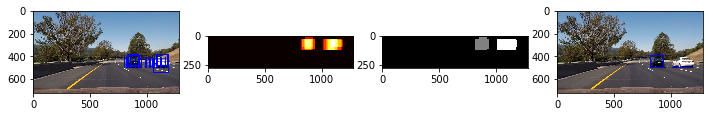

CPU times: user 546 ms, sys: 22.1 ms, total: 568 ms
Wall time: 626 ms


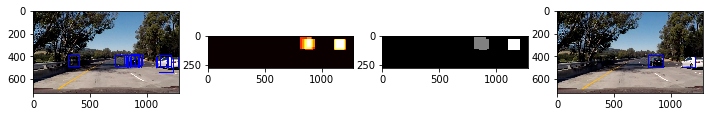

CPU times: user 294 ms, sys: 57.1 ms, total: 351 ms
Wall time: 621 ms


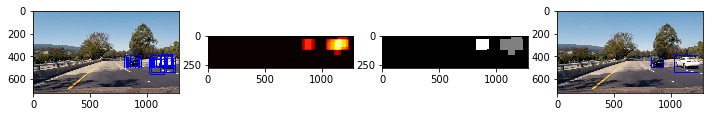

CPU times: user 332 ms, sys: 63.5 ms, total: 396 ms
Wall time: 618 ms


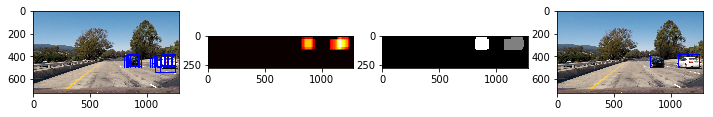

CPU times: user 333 ms, sys: 51.3 ms, total: 385 ms
Wall time: 609 ms


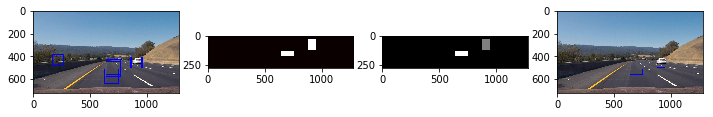

CPU times: user 348 ms, sys: 48.6 ms, total: 397 ms
Wall time: 604 ms


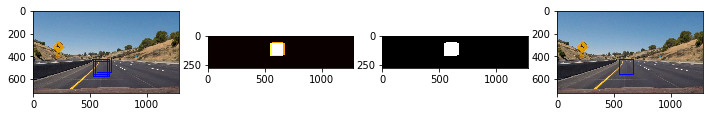

In [147]:
test_imgs = glob.glob('test_images/*.jpg')
with Pool(pool_size) as test_pool:
    for i, img in enumerate(test_imgs):
        img = mpimg.imread(img)
        search_img = prepare_image(img, 380, 656) 
        %time candidates = f_candidates(search_img, i, test_pool, step=225)
        candidates_img = draw_boxes(img, candidates, y_prefix=y_prefix, color=(0,0,255), thick = 6)
        heatmap = np.zeros_like(search_img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, candidates)
        heatmap = apply_threshold(heatmap, 2)
        labels = label(heatmap)
        bbox_list = bbox_from_labels(labels)        
        result_img = draw_boxes(img, bbox_list, y_prefix=y_prefix, color=(0,0,255), thick = 6)
        _, ax = plt.subplots(1, 4, figsize = (12, 8))
        ax[0].imshow(candidates_img)
        ax[1].imshow(heatmap, cmap = 'hot')
        ax[2].imshow(labels[0], cmap = 'gray')
        ax[3].imshow(result_img)
        plt.show()
test_pool.join() 

#### Video

In [148]:
# Class for video frame processing 
class VehicleDetector():
    def __init__(self):
        
        self.candidates_cache = [] #cache to store last n candidates
        self.cache_size = 6 # candidates cache size
        self.heat_threshold = 2 # heat threshold 
        self.cache_threshold = 3 # theshold over cached candidates
        
        self.box_color = (0,0,255)
        self.box_thick = 6
        self.y_start = 380 # upper window border 
        self.y_stop = 656  # lower window border
        
        self.pool = Pool(pool_size) # processing pool
        self.count = 0
    
    # clean up
    def close(self):
        self.pool.close()
        self.pool.join()

    # search for candiadates    
    def find_candidates(self, img):
        return f_candidates(img, self.count, self.pool, step=225)
    
    def apply_heatmap(self, img, candidates, threshold):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, candidates)
        heatmap = apply_threshold(heatmap, threshold)
        labels = label(heatmap)
        return bbox_from_labels(labels)
    
    # apply heat map to window candidates and cached candidates
    def filter_candidates(self, img, candidates):  
        c = candidates if len(candidates) == 0 else self.apply_heatmap(img, candidates, self.heat_threshold)         
        self.candidates_cache.append(c)            
        if len(self.candidates_cache) > self.cache_size: self.candidates_cache.pop(0)  
        all_candidates = [b for c in self.candidates_cache for b in c]        
        return self.apply_heatmap(img, all_candidates, self.cache_threshold)    

    # draw rectangles over frame
    def draw(self, img, candidates):
        return draw_boxes(img, candidates, y_prefix=self.y_start, color=self.box_color, thick = self.box_thick)      
    
    # process a frame
    def process(self, img):
        sub_img = prepare_image(img, self.y_start, self.y_stop) 
        candidates = self.find_candidates(sub_img)
        candidates = self.filter_candidates(sub_img, candidates)
        self.count += 1 
        if len(candidates) > 0:
            return self.draw(img, candidates)
        else:
            return img
      

In [149]:
detector = VehicleDetector()
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(detector.process)

%time project_clip.write_videofile('output_images/proc_project_video.mp4', audio = False)

detector.close()


[MoviePy] >>>> Building video output_images/proc_project_video.mp4
[MoviePy] Writing video output_images/proc_project_video.mp4


100%|█████████▉| 1260/1261 [14:07<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/proc_project_video.mp4 

CPU times: user 4min 15s, sys: 1min 27s, total: 5min 42s
Wall time: 14min 8s


In [150]:
video = 'output_images/proc_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))